In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

In [2]:
base_dir = './input/dataset/'

# 关闭execution防止报错
tf.compat.v1.disable_eager_execution()

# 归一化处理
def process_image(image):
    return image / 255.

def load_data(path):
    high_res_images = []
    low_res_images = []
    for dirname, _, filenames in os.walk(path + 'low_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = process_image(img)
            low_res_images.append(img)

    for dirname, _, filenames in os.walk(path + 'high_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = process_image(img)
            high_res_images.append(img)

    return np.array(low_res_images), np.array(high_res_images)

In [3]:
train_x, train_y = load_data(base_dir + 'train/')
val_x, val_y = load_data(base_dir + 'val/')


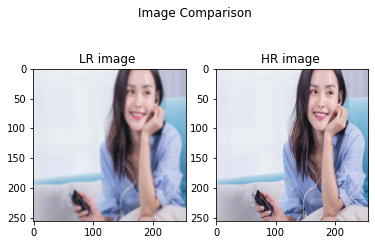

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Image Comparison')
ax1.imshow(train_x[615])
ax1.title.set_text("LR image ")
ax2.imshow(train_y[615])
ax2.title.set_text("HR image ")
plt.show()

In [5]:
def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(input_img)  # 正则化
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l1)

    l3 = MaxPooling2D(padding='same')(l2)
    l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l4)

    l6 = MaxPooling2D(padding='same')(l5)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l6)

    l8 = UpSampling2D()(l7)

    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l9)

    l11 = add([l5, l10])
    l12 = UpSampling2D()(l11)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l13)

    l15 = add([l14, l2])

    decoded = Conv2D(3, (3, 3), padding='same', activation='relu',
                     activity_regularizer=regularizers.l1(10e-10))(l15)

    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])

    print(model.summary())
    return model



In [6]:
model=build_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [7]:
epochs=10
history=model.fit(train_x, train_y, epochs=epochs, batch_size=8, shuffle=True, 
          validation_data=(val_x, val_y))

Train on 685 samples, validate on 170 samples
Epoch 1/10
685/685 [==============================] - ETA: 0s - loss: 0.0155 - acc: 0.6547

d:\python\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


685/685 [==============================] - 31s 45ms/sample - loss: 0.0155 - acc: 0.6547 - val_loss: 0.0027 - val_acc: 0.7442
Epoch 2/10
685/685 [==============================] - 21s 31ms/sample - loss: 0.0022 - acc: 0.8318 - val_loss: 0.0020 - val_acc: 0.8942
Epoch 3/10
685/685 [==============================] - 21s 31ms/sample - loss: 0.0018 - acc: 0.8453 - val_loss: 0.0018 - val_acc: 0.8131
Epoch 4/10
685/685 [==============================] - 21s 31ms/sample - loss: 0.0017 - acc: 0.8577 - val_loss: 0.0017 - val_acc: 0.9149
Epoch 5/10
685/685 [==============================] - 22s 32ms/sample - loss: 0.0016 - acc: 0.8616 - val_loss: 0.0016 - val_acc: 0.8650
Epoch 6/10
685/685 [==============================] - 21s 31ms/sample - loss: 0.0015 - acc: 0.8645 - val_loss: 0.0015 - val_acc: 0.9006
Epoch 7/10
685/685 [==============================] - 22s 31ms/sample - loss: 0.0014 - acc: 0.8685 - val_loss: 0.0014 - val_acc: 0.8551
Epoch 8/10
685/685 [==============================] - 22s 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


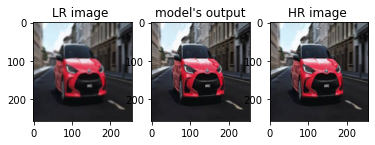

In [8]:
predict_y = model.predict(val_x)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(val_x[3])
ax1.title.set_text("LR image ")

ax2.imshow(predict_y[3])
ax2.title.set_text("model's output")

ax3.imshow(val_y[3])
ax3.title.set_text("HR image ")
plt.show()

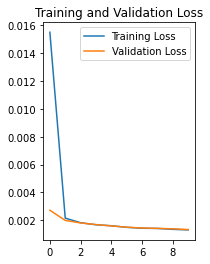

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


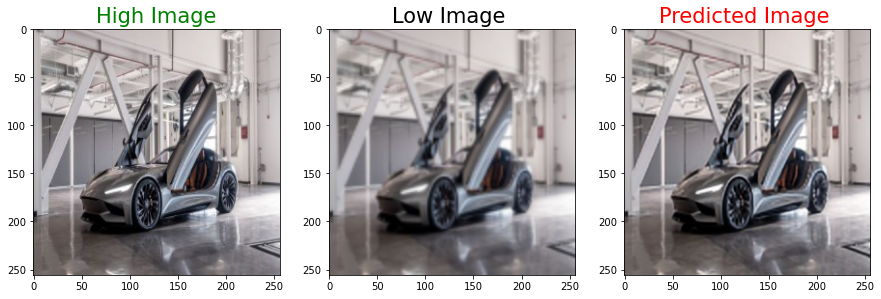

C:\Users\lenovo\AppData\Local\Temp/ipykernel_7636/2757235926.py:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr = compare_psnr(hr, pre)
d:\python\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：30.155672730734683，SSIM：0.9565852442835543


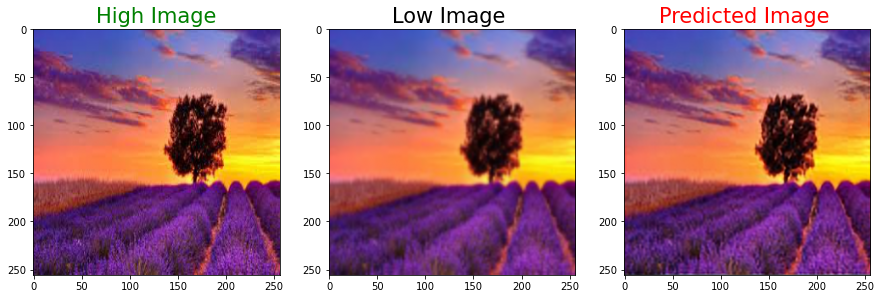

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：31.84198014737798，SSIM：0.9494416300919849


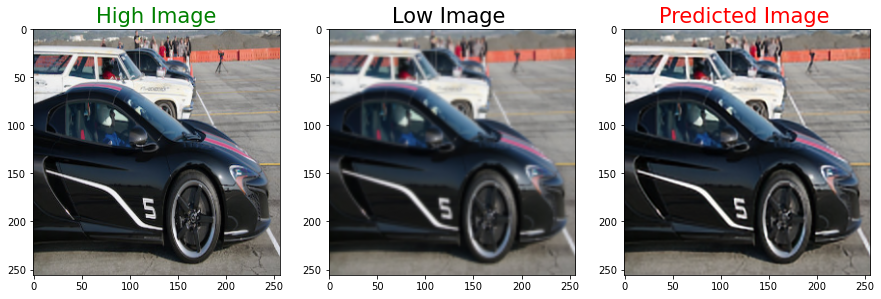

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：29.053791928220353，SSIM：0.9473981051017338


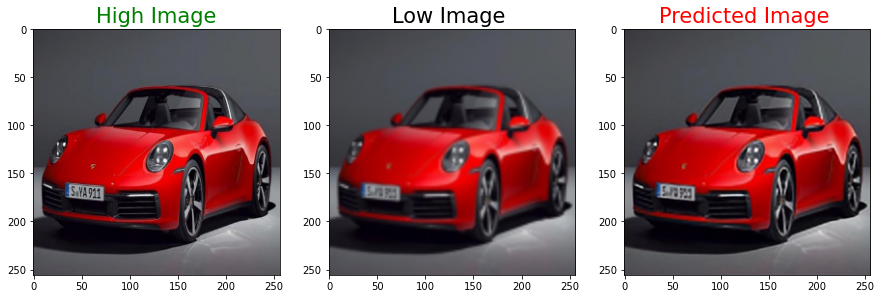

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：31.23356261743076，SSIM：0.9682145048331893


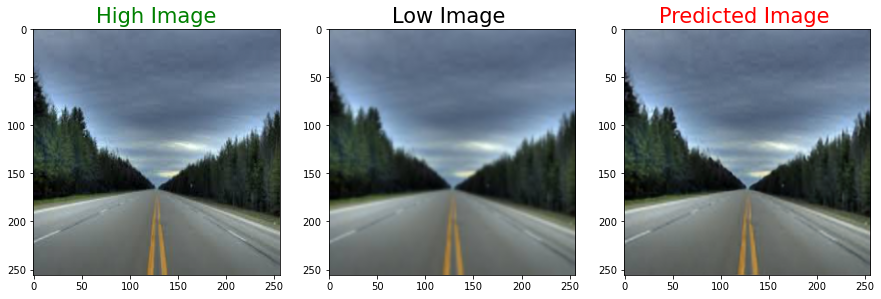

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：38.039514143384565，SSIM：0.9885261097089719


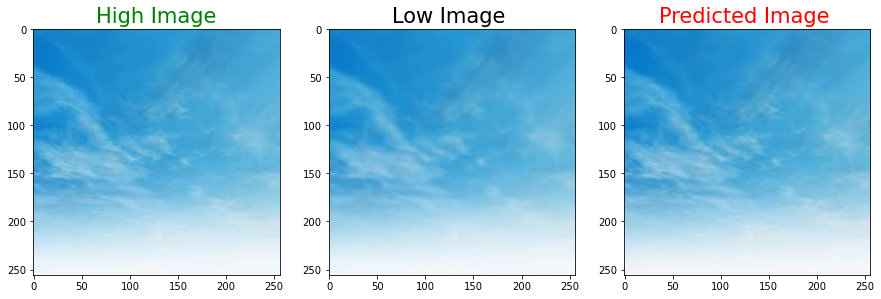

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：41.747558148871065，SSIM：0.9952129181201563


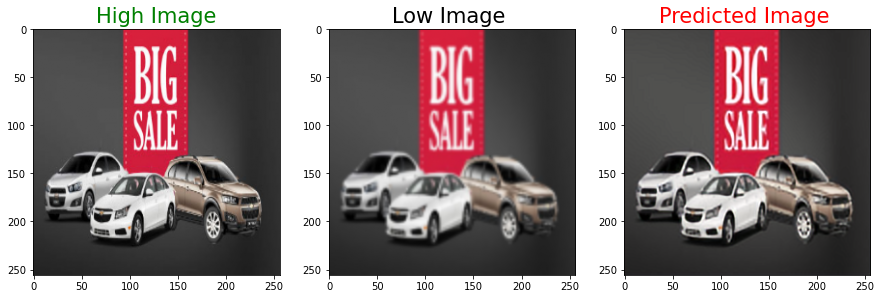

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：29.421200887243636，SSIM：0.970116320987748


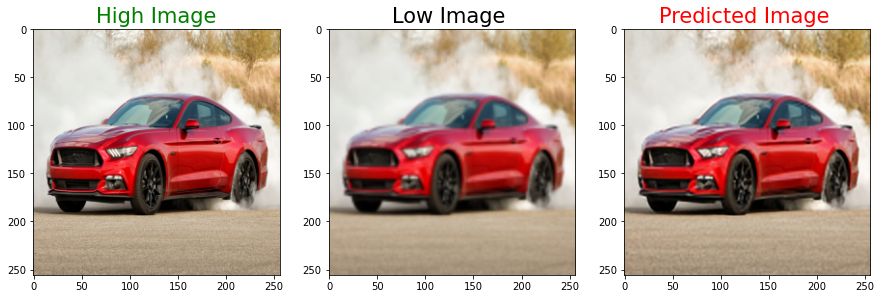

原图和输出图像比较后，PSNR：30.786512404928796，SSIM：0.9452768775242495


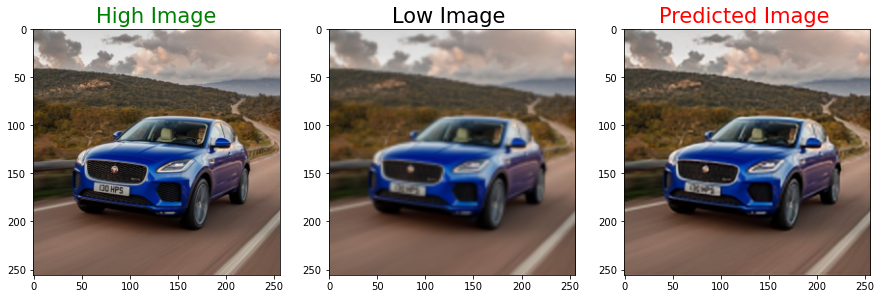

原图和输出图像比较后，PSNR：31.75201352160997，SSIM：0.9640499001160054


In [10]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

def plot_images(high, low, predicted):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('High Image', color='green', fontsize=21)
    plt.imshow(high)
    plt.subplot(1, 3, 2)
    plt.title('Low Image ', color='black', fontsize=21)
    plt.imshow(low)
    plt.subplot(1, 3, 3)
    plt.title('Predicted Image ', color='red', fontsize=21)
    plt.imshow(predicted)

    plt.show()
   
def PSNR_SSIM(hr, pre):
    psnr = compare_psnr(hr, pre)
    ssim = compare_ssim(hr, pre, multichannel=True)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    print('原图和输出图像比较后，PSNR：{}，SSIM：{}'.format(psnr, ssim))


for i in range(16, 25):
    #predict_y = np.clip(model.predict(val_x[i].reshape(1,256, 256,3)),0.0,1.0).reshape(256, 256,3)
    plot_images(val_y[i], val_x[i], predict_y[i])
    #print('PSNR', PSNR(val_y[i], predict_y[i]), 'dB')
    PSNR_SSIM(val_y[i],predict_y[i])

In [11]:
model.save('FSRCNN.h5')

d:\python\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
